In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import squidpy as sq

import os
from tqdm import tqdm
from pathlib import Path

In [2]:
base_dir = Path().resolve().parent.parent
base_dir

PosixPath('/home/sadegh/python_projects/teesside/nanostring-cosmx-spatial-omics-modeling')

## Metabolic Task Significant Analysis by t-test

In [3]:
df = pd.read_csv(base_dir / 'data/All_Metabolic_Tasks.csv')
df

,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic conditions) - glycolysis,ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,Acetoacetate synthesis,Alanine degradation,Alanine synthesis,Arachidonate degradation,Arachidonate synthesis,Arginine degradation,Arginine synthesis,...,beta-Alanine synthesis,cis-vaccenic acid degradation,cis-vaccenic acid synthesis,gamma-Linolenate degradation,Subject_ID,Treatment_Status,Cell_ID,Cell_type,x,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1182412B,Untreated,TMA2_1_303,Malignant,-481975.375698,8092.453408
1,3.596589,3.596589,1.593463,3.596589,2.363587,3.596589,1.388632,1.666016,2.688572,3.596589,...,3.596589,1.506556,0.828416,1.506556,1182412B,Untreated,TMA2_3_303,Malignant,-481865.375698,7851.453408
2,1.262172,1.262172,0.683991,1.262172,2.010341,1.262172,0.736895,0.736804,0.653205,1.262172,...,1.262172,3.839008,0.379129,3.839008,1182412B,Untreated,TMA2_6_303,Malignant,-480421.375698,6738.453408
3,0.941260,0.941260,0.617541,0.941260,0.652265,0.941260,0.764453,0.736154,0.465586,0.941260,...,0.941260,1.021286,0.348070,1.021286,1182412B,Untreated,TMA2_8_303,Malignant,-480420.375698,6614.453408
4,18.998492,18.998492,5.560580,18.998492,5.922492,18.998492,1.621913,5.685172,7.343501,18.998492,...,18.998492,2.281059,2.585627,2.281059,1182412B,Untreated,TMA2_9_303,Malignant,-480494.375698,6607.453408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2139956,0.000000,0.000000,0.000000,0.000000,0.065008,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.252118,0.000000,0.252118,1185092B,Untreated,TMA2_223_302,Plasma_IgG,-470201.968263,-72967.018989
2139957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.942360,0.544111,5.942360,1185092B,Untreated,TMA2_231_302,Plasma_IgG,-470619.968263,-73036.018989
2139958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051084,0.000000,0.000000,...,0.000000,0.375187,0.054611,0.375187,1185092B,Untreated,TMA2_236_302,Plasma_IgG,-470193.968263,-73111.018989
2139959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1185092B,Untreated,TMA2_238_302,Fib_ECM,-469892.968263,-73112.018989


In [4]:
tasks_meta_data = pd.read_csv(base_dir / 'data/Task_Info_with_CRC_binary.csv')
tasks_meta_data

,Task,System,Subsystem,Upregulated_in_CRC
0,(R)-3-Hydroxybutanoate synthesis,CARBOHYDRATES METABOLISM,KETOGENESIS,0
1,3'-Phospho-5'-adenylyl sulfate synthesis,NUCLEOTIDE METABOLISM,COFACTOR,0
2,AMP salvage from adenine,NUCLEOTIDE METABOLISM,SALVAGE,0
3,ATP generation from glucose (hypoxic condition...,ENERGY METABOLISM,ATP GENERATION,1
4,ATP regeneration from glucose (normoxic condit...,ENERGY METABOLISM,ATP GENERATION,0
...,...,...,...,...
213,Synthesis of androstenedione from cholesterol,HORMONES METABOLISM,ANDROGEN METABOLISM,0
214,Synthesis of estradiol-17beta (E2) from andros...,HORMONES METABOLISM,ESTROGEN METABOLISM,0
215,Synthesis of estrone (E1) from androstenedione,HORMONES METABOLISM,ESTROGEN METABOLISM,0
216,Synthesis of progesterone from cholesterol,HORMONES METABOLISM,PROGESTERONE METABOLISM,0


In [5]:
meta_cols = ["Subject_ID", "Treatment_Status", "Cell_ID", "Cell_type", "x", "y"]
task_cols = [c for c in df.columns if c not in meta_cols]

In [6]:
cell_type_masks = {
    "Macrophage": df["Cell_type"].str.startswith("Mph_"),
    "Fibroblast": df["Cell_type"].str.startswith("Fib_"),
    "Malignant": df["Cell_type"] == "Malignant"
}

In [7]:
def ttest_metabolic_tasks(
    df,
    task_cols,
    cell_mask,
    task_meta_df,
    alpha=0.05,
    pseudocount=1e-6
):
    out = []

    sub = df[cell_mask]

    treated = sub[sub["Treatment_Status"] == "Treated"]
    control = sub[sub["Treatment_Status"] == "Untreated"]

    for task in task_cols:
        t_stat, p_val = ttest_ind(
            treated[task],
            control[task],
            equal_var=False,
            nan_policy="omit"
        )

        mean_treated = treated[task].mean()
        mean_control = control[task].mean()

        std_treated = treated[task].std()
        std_control = control[task].std()

        fold_change = (mean_treated + pseudocount) / (mean_control + pseudocount)
        log2_fc = np.log2(fold_change)

        out.append({
            "Task": task,

            "mean_treated": mean_treated,
            "std_treated": std_treated,

            "mean_untreated": mean_control,
            "std_untreated": std_control,

            "fold_change": fold_change,
            "log2_fold_change": log2_fc,

            "t_stat": t_stat,
            "p_value": p_val,
            "significant": p_val < alpha,

            "n_treated": treated.shape[0],
            "n_untreated": control.shape[0],
        })

    res_df = pd.DataFrame(out)

    # add System & Subsystem
    res_df = res_df.merge(
        task_meta_df[["Task", "System", "Subsystem"]],
        on="Task",
        how="left"
    )

    return res_df


In [8]:
results = []

for ct_name, mask in cell_type_masks.items():
    res = ttest_metabolic_tasks(df, task_cols, mask, tasks_meta_data)
    res["cell_type_group"] = ct_name
    results.append(res)

df_results = pd.concat(results, ignore_index=True)
df_results

,Task,mean_treated,std_treated,mean_untreated,std_untreated,fold_change,log2_fold_change,t_stat,p_value,significant,n_treated,n_untreated,System,Subsystem,cell_type_group
0,(R)-3-Hydroxybutanoate synthesis,4.022869,4.643065,4.346352,5.034713,0.925574,-0.111580,-11.494620,1.457543e-30,True,57303,60968,CARBOHYDRATES METABOLISM,KETOGENESIS,Macrophage
1,ATP generation from glucose (hypoxic condition...,4.022869,4.643065,4.346352,5.034713,0.925574,-0.111580,-11.494620,1.457543e-30,True,57303,60968,ENERGY METABOLISM,ATP GENERATION,Macrophage
2,ATP regeneration from glucose (normoxic condit...,1.478084,1.423018,1.545478,1.510595,0.956393,-0.064325,-7.900555,2.800326e-15,True,57303,60968,ENERGY METABOLISM,ATP GENERATION,Macrophage
3,Acetoacetate synthesis,4.022869,4.643065,4.346352,5.034713,0.925574,-0.111580,-11.494620,1.457543e-30,True,57303,60968,LIPIDS METABOLISM,CHOLESTEROL METABOLISM,Macrophage
4,Alanine degradation,3.093847,1.882766,3.170343,2.000646,0.975871,-0.035237,-6.774380,1.255224e-11,True,57303,60968,AMINO ACIDS METABOLISM,ALANINE METABOLISM,Macrophage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,beta-Alanine degradation,2.011636,1.205713,2.016535,1.314903,0.997571,-0.003509,-1.909711,5.617070e-02,False,402496,582312,AMINO ACIDS METABOLISM,BETA-ALANINE METABOLISM,Malignant
296,beta-Alanine synthesis,4.613928,4.085710,4.142144,4.239875,1.113899,0.155618,55.467718,0.000000e+00,True,402496,582312,AMINO ACIDS METABOLISM,BETA-ALANINE METABOLISM,Malignant
297,cis-vaccenic acid degradation,3.269476,1.886264,2.793333,1.978828,1.170457,0.227072,120.690272,0.000000e+00,True,402496,582312,LIPIDS METABOLISM,FATTY ACID METABOLISM,Malignant
298,cis-vaccenic acid synthesis,1.092658,0.658557,1.002718,0.684241,1.089697,0.123927,65.569171,0.000000e+00,True,402496,582312,LIPIDS METABOLISM,FATTY ACID METABOLISM,Malignant


In [9]:
df_results.columns

Index(['Task', 'mean_treated', 'std_treated', 'mean_untreated',
       'std_untreated', 'fold_change', 'log2_fold_change', 't_stat', 'p_value',
       'significant', 'n_treated', 'n_untreated', 'System', 'Subsystem',
       'cell_type_group'],
      dtype='object')

In [10]:
sig_counts = (
    df_results[df_results['significant']]
    .groupby('cell_type_group')
    .size()
    .reset_index(name='n_significant')
)
sig_counts

,cell_type_group,n_significant
0,Fibroblast,81
1,Macrophage,96
2,Malignant,96


In [11]:
def plot_tasks_by_celltype(df, cell_type, top_n=10):
    sub = df[
        (df["cell_type_group"] == cell_type) &
        (df["significant"] == True)
    ]

    up = (
        sub[sub["log2_fold_change"] > 0]
        .sort_values("log2_fold_change", ascending=False)
        .head(top_n)
    )

    down = (
        sub[sub["log2_fold_change"] < 0]
        .sort_values("log2_fold_change")
        .head(top_n)
    )

    plot_df = (
        pd.concat([up, down])
        .sort_values("log2_fold_change")
    )

    colors = plot_df["log2_fold_change"].apply(
        lambda x: "red" if x > 0 else "blue"
    )

    plt.figure(figsize=(8, 4))
    plt.barh(plot_df["Task"], plot_df["log2_fold_change"])

    for bar, c in zip(plt.gca().patches, colors):
        bar.set_color(c)

    plt.axvline(0)
    plt.xlabel("log2FC (Treated vs Untreated)")
    plt.title(f"Differential Metabolic Tasks – {cell_type}")
    plt.tight_layout()
    plt.show()

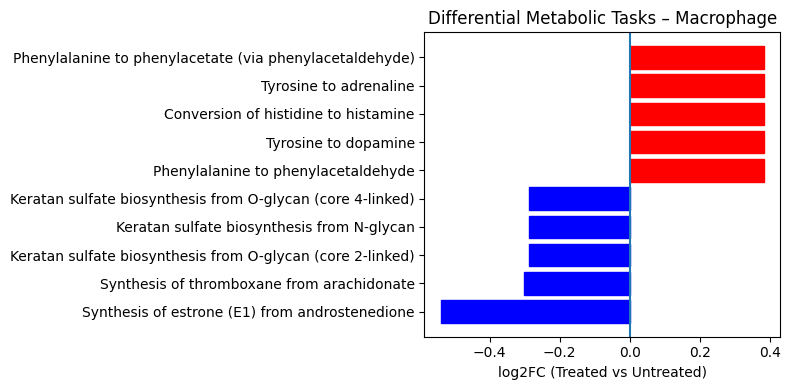

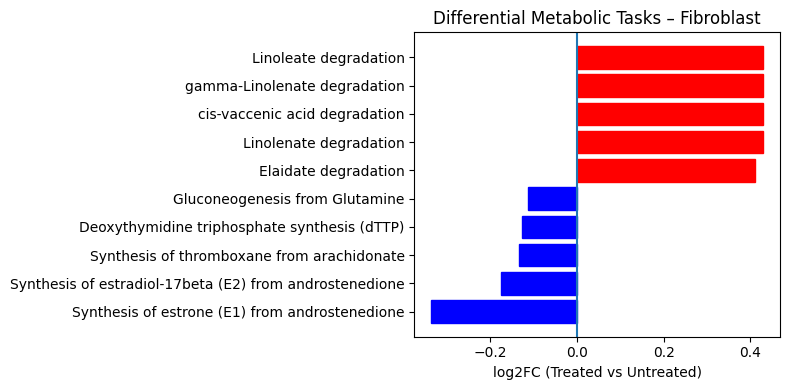

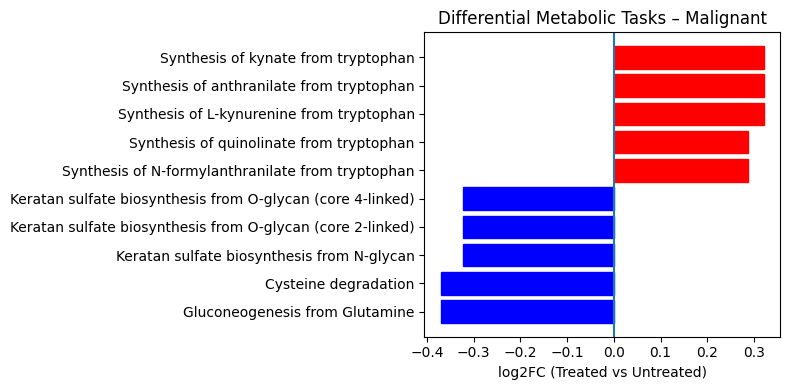

In [12]:
for ct in df_results["cell_type_group"].unique():
    plot_tasks_by_celltype(df_results, ct, 5)

In [13]:
def count_significant_tasks_by_system(df, cell_type):
    sub = df[
        (df["cell_type_group"] == cell_type) &
        (df["significant"] == True)
    ]

    counts = (
        sub.groupby("System")
        .size()
        .reset_index(name="n_significant_tasks")
        .sort_values("n_significant_tasks", ascending=False)
    )

    return counts

In [14]:
def plot_system_counts(df, cell_type):
    counts = count_significant_tasks_by_system(df, cell_type)
    counts = counts.sort_values("n_significant_tasks")

    plt.figure(figsize=(8, 4))

    bars = plt.barh(
        counts["System"],
        counts["n_significant_tasks"],
        alpha=0.85
    )

    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.1,
            bar.get_y() + bar.get_height() / 2,
            f"{int(width)}",
            va="center",
            fontsize=9
        )

    plt.xlabel("Number of significantly different tasks", fontsize=10)
    plt.title(
        f"Significant Metabolic Tasks per System\n({cell_type}s)",
        fontsize=11
    )

    plt.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [15]:
def plot_subsystem_counts(df, cell_type, top_n=15):
    sub = df[
        (df["cell_type_group"] == cell_type) &
        (df["significant"] == True)
    ]

    counts = (
        sub.groupby("Subsystem")
        .size()
        .reset_index(name="n_significant_tasks")
        .sort_values("n_significant_tasks", ascending=False)
        .head(top_n)
        .sort_values("n_significant_tasks")
    )

    plt.figure(figsize=(8, 5))

    bars = plt.barh(
        counts["Subsystem"],
        counts["n_significant_tasks"],
        alpha=0.85
    )

    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + 0.1,
            bar.get_y() + bar.get_height() / 2,
            f"{int(width)}",
            va="center",
            fontsize=9
        )

    plt.xlabel("Number of significantly different tasks", fontsize=10)
    plt.title(
        f"Significant Metabolic Tasks per Subsystem\n({cell_type}s)",
        fontsize=11
    )

    plt.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()



Cell type: Macrophage


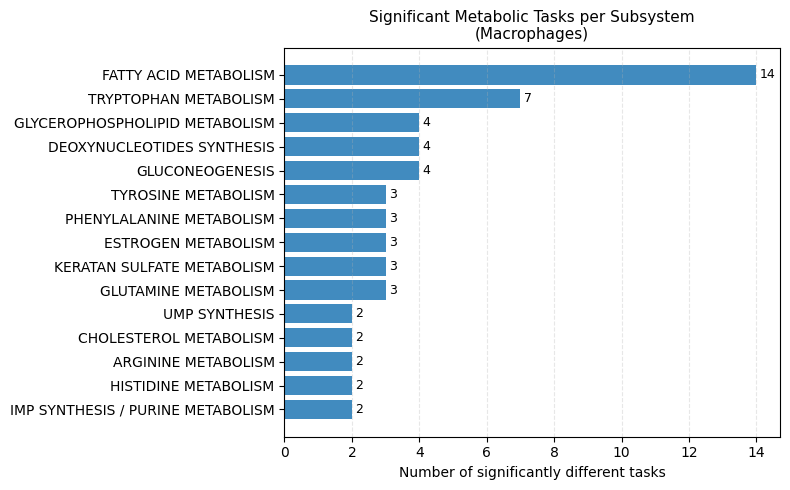

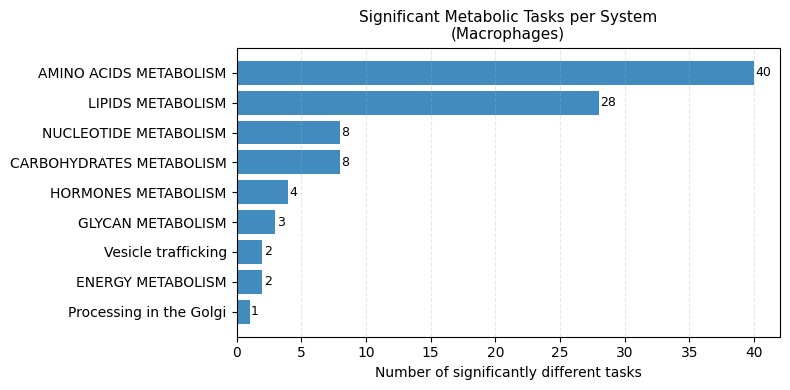


Cell type: Fibroblast


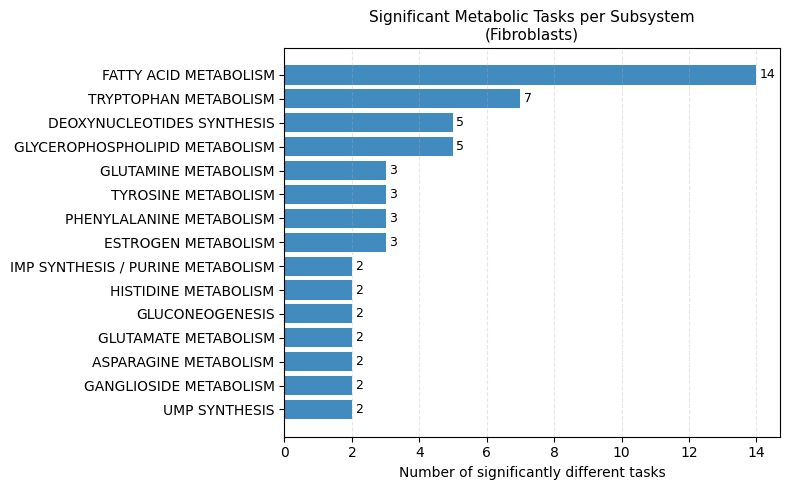

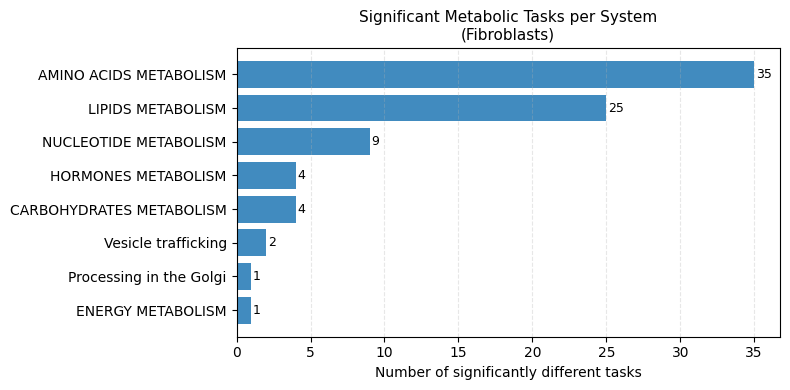


Cell type: Malignant


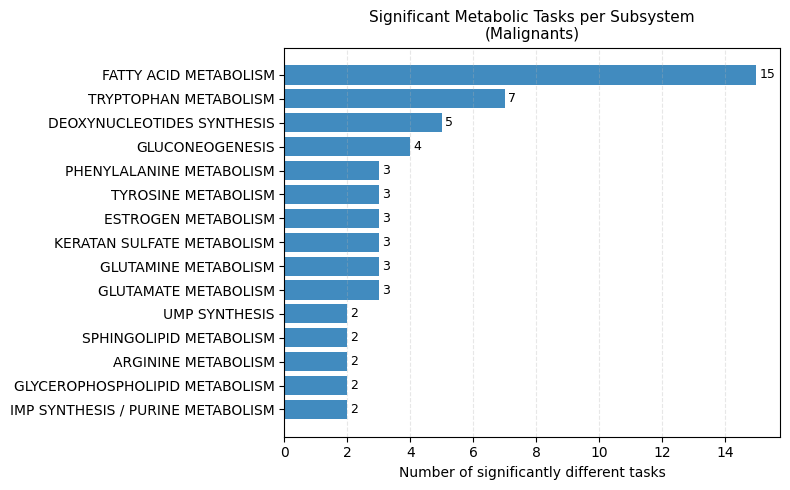

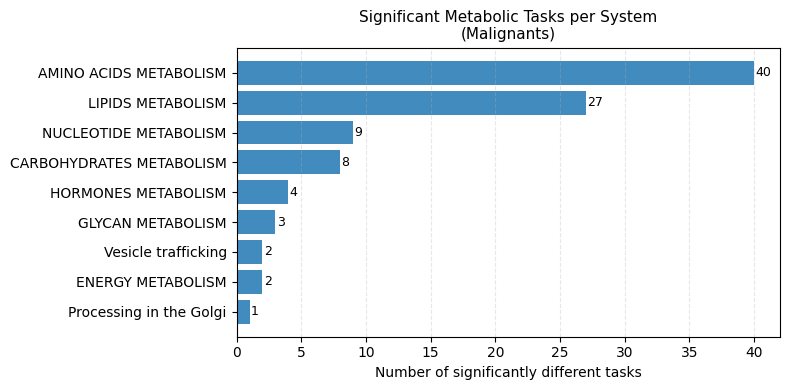

In [16]:
for ct in df_results["cell_type_group"].unique():
    print(f"\nCell type: {ct}")
    plot_subsystem_counts(df_results, ct)
    plot_system_counts(df_results, ct)

## Tumor Infilitrating T/NK-Cells Analysis

In [17]:
sccellfie_root = base_dir / "sccellfie_results"
output_root = base_dir / "metabolic_tasks_and_reaction_with_TNKscore"
os.makedirs(output_root, exist_ok=True)

RADIUS = 180   # 180 px ≈ 21.6 µm
THRESHOLD = 0.2

patients = [
    p for p in os.listdir(sccellfie_root)
    if os.path.isdir(os.path.join(sccellfie_root, p))
]

In [18]:
# Calculate TNK-Malignant score for each patient and save new h5ad files with the score in obs

for pid in tqdm(patients):

    out_dir = os.path.join(output_root, pid)
    out_path = os.path.join(out_dir, f"{pid}_with_TNKscore.h5ad")

    if os.path.exists(out_path):
        print(f"Skipping {pid} (already processed)")
        continue

    try:
        print(f"Processing {pid}")

        # paths
        adata_path = os.path.join(sccellfie_root, pid, f"{pid}.h5ad")
        task_path  = os.path.join(sccellfie_root, pid, f"{pid}_metabolic_tasks.h5ad")
        rxn_path   = os.path.join(sccellfie_root, pid, f"{pid}_reactions.h5ad")

        # load
        adata = sc.read_h5ad(adata_path)
        adata_tasks = sc.read_h5ad(task_path)
        adata_rxn = sc.read_h5ad(rxn_path)

        # attach metabolic matrices
        adata.obsm["met_tasks"] = adata_tasks.X
        adata.uns["met_task_names"] = list(adata_tasks.var_names)

        adata.obsm["rxn"] = adata_rxn.X
        adata.uns["rxn_names"] = list(adata_rxn.var_names)

        # Build spatial graph
        sq.gr.spatial_neighbors(
            adata,
            radius=RADIUS,
            coord_type="generic"
        )

        conn = adata.obsp["spatial_connectivities"].tocsr()

        labels = adata.obs["Lineage_level3"]

        is_tnk = (labels == "T_NK").values
        is_malignant = (labels == "Malignant").values

        mal_score = np.zeros(adata.n_obs)

        tnk_idx = np.where(is_tnk)[0]

        for i in tnk_idx:

            neighbors = conn.indices[conn.indptr[i]:conn.indptr[i+1]]

            if len(neighbors) == 0:
                mal_score[i] = 0.0
                continue

            mal_neighbors = neighbors[is_malignant[neighbors]]

            mal_score[i] = len(mal_neighbors) / len(neighbors)

        adata.obs["TNK_MalignantScore"] = mal_score

        # save
        os.makedirs(out_dir, exist_ok=True)
        adata.write(out_path)

    except Exception as e:
        print(f"FAILED on {pid}: {e}")

100%|██████████| 24/24 [00:00<00:00, 23269.37it/s]

Skipping 1182412B (already processed)
Skipping 118223A (already processed)
Skipping 468115 (already processed)
Skipping 1258057B (already processed)
Skipping 120139 (already processed)
Skipping 114262 (already processed)
Skipping 1182623B (already processed)
Skipping 1228762B (already processed)
Skipping 1204245B (already processed)
Skipping 120153 (already processed)
Skipping 1180097B (already processed)
Skipping 95278A2 (already processed)
Skipping 1207356B (already processed)
Skipping 1209622B (already processed)
Skipping 120140 (already processed)
Skipping 120136 (already processed)
Skipping 92604 (already processed)
Skipping 78410A1 (already processed)
Skipping 120149 (already processed)
Skipping 1216278B (already processed)
Skipping 89397 (already processed)
Skipping 1192325B (already processed)
Skipping 120161 (already processed)
Skipping 1185092B (already processed)


### T/NK infiltration ratio analysis

In [19]:
records = []

for pid in tqdm(patients):
    try:
        adata_path = os.path.join(sccellfie_root, pid, f"{pid}.h5ad")
        task_path  = os.path.join(sccellfie_root, pid, f"{pid}_metabolic_tasks.h5ad")
        rxn_path   = os.path.join(sccellfie_root, pid, f"{pid}_reactions.h5ad")

        adata = sc.read_h5ad(adata_path)
        adata_tasks = sc.read_h5ad(task_path)
        adata_rxn = sc.read_h5ad(rxn_path)

        # attach metabolic matrices
        adata.obsm["met_tasks"] = adata_tasks.X
        adata.obsm["rxn"] = adata_rxn.X

        # build spatial neighbors (radius-based)
        sq.gr.spatial_neighbors(
            adata,
            radius=RADIUS,
            coord_type="generic"
        )

        conn = adata.obsp["spatial_connectivities"].tocsr()

        labels = adata.obs["Lineage_level3"]

        is_tnk = (labels == "T_NK").values
        is_malignant = (labels == "Malignant").values

        tnk_idx = np.where(is_tnk)[0]

        mal_score = np.zeros(len(tnk_idx))

        for j, i in enumerate(tnk_idx):
            neighbors = conn.indices[conn.indptr[i]:conn.indptr[i+1]]

            if len(neighbors) == 0:
                mal_score[j] = 0.0
            else:
                mal_neighbors = neighbors[is_malignant[neighbors]]
                mal_score[j] = len(mal_neighbors) / len(neighbors)

        n_tnk = len(tnk_idx)
        n_tnk_infil = int(np.sum(mal_score >= THRESHOLD))

        treatment_status = (
            adata.obs["Treatment_Status"].iloc[0]
            if "Treatment_Status" in adata.obs.columns
            else "Unknown"
        )

        records.append({
            "patient_id": pid,
            "treatment_status": treatment_status,
            "TNK_total": n_tnk,
            "TNK_infiltrating": n_tnk_infil,
            "TNK_infiltrating_ratio": (
                n_tnk_infil / n_tnk if n_tnk > 0 else 0
            )
        })

    except Exception as e:
        records.append({
            "patient_id": pid,
            "treatment_status": "FAILED",
            "TNK_total": np.nan,
            "TNK_infiltrating": np.nan,
            "TNK_infiltrating_ratio": np.nan,
            "error": str(e)
        })

df_tnk = pd.DataFrame(records)
df_tnk

  0%|          | 0/24 [00:00<?, ?it/s]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


  4%|▍         | 1/24 [00:05<02:06,  5.51s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


  8%|▊         | 2/24 [00:13<02:39,  7.25s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 12%|█▎        | 3/24 [00:26<03:19,  9.50s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 17%|█▋        | 4/24 [00:30<02:31,  7.60s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 21%|██        | 5/24 [00:38<02:26,  7.71s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 25%|██▌       | 6/24 [00:39<01:37,  5.42s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 29%|██▉       | 7/24 [00:49<01:54,  6.76s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 33%|███▎      | 8/24 [00:53<01:33,  5.87s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 38%|███▊      | 9/24 [00:58<01:24,  5.61s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 42%|████▏     | 10/24 [01:10<01:48,  7.77s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 46%|████▌     | 11/24 [01:18<01:41,  7.83s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 50%|█████     | 12/24 [01:20<01:11,  5.98s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 54%|█████▍    | 13/24 [01:33<01:28,  8.05s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 58%|█████▊    | 14/24 [01:47<01:39,  9.91s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 62%|██████▎   | 15/24 [01:55<01:23,  9.31s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 67%|██████▋   | 16/24 [01:59<01:01,  7.73s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 71%|███████   | 17/24 [02:08<00:56,  8.11s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 75%|███████▌  | 18/24 [02:17<00:50,  8.36s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 79%|███████▉  | 19/24 [02:19<00:32,  6.45s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 83%|████████▎ | 20/24 [02:28<00:29,  7.28s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 88%|████████▊ | 21/24 [02:38<00:23,  8.00s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 92%|█████████▏| 22/24 [02:47<00:16,  8.29s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


 96%|█████████▌| 23/24 [02:57<00:08,  8.83s/it]

INFO     Creating graph using `generic` coordinates and `None` transform and `1` libraries.                        


100%|██████████| 24/24 [03:01<00:00,  7.55s/it]


,patient_id,treatment_status,TNK_total,TNK_infiltrating,TNK_infiltrating_ratio
0,1182412B,Untreated,950,298,0.313684
1,118223A,Untreated,2257,406,0.179885
2,468115,Treated,6873,1403,0.204132
3,1258057B,Untreated,5568,532,0.095546
4,120139,Treated,1068,162,0.151685
5,114262,Treated,295,136,0.461017
6,1182623B,Untreated,2811,908,0.323017
7,1228762B,Untreated,979,44,0.044944
8,1204245B,Untreated,475,31,0.065263
9,120153,Treated,7617,1529,0.200735


In [20]:
df_tnk.groupby("treatment_status")["TNK_infiltrating"].sum()

treatment_status
Treated      7886
Untreated    7696
Name: TNK_infiltrating, dtype: int64

### T/NK infilitrating Significant Metabolic Task Co-Localization Analysis

In [21]:
sig_tasks = (
    df_results
    .sort_values("p_value")
    .groupby("cell_type_group")
    .first()
)
sig_tasks

,Task,mean_treated,std_treated,mean_untreated,std_untreated,fold_change,log2_fold_change,t_stat,p_value,significant,n_treated,n_untreated,System,Subsystem
cell_type_group,,,,,,,,,,,,,,
Fibroblast,gamma-Linolenate degradation,3.536826,2.289270,2.624318,2.239936,1.347712,0.430513,114.828191,0.0,True,134047,208585,LIPIDS METABOLISM,FATTY ACID METABOLISM
Macrophage,Elaidate degradation,3.567529,1.826031,2.982544,1.940226,1.196136,0.258382,53.416306,0.0,True,57303,60968,LIPIDS METABOLISM,FATTY ACID METABOLISM
Malignant,gamma-Linolenate degradation,3.269476,1.886264,2.793333,1.978828,1.170457,0.227072,120.690272,0.0,True,402496,582312,LIPIDS METABOLISM,FATTY ACID METABOLISM


In [22]:
# sig_tasks.to_csv('Selected_Significant_Task_per_celltype.csv')

In [23]:
def compute_colocalization_per_patient(
    adata,
    sig_tasks,
    infiltration_thr=0.0
):

    labels = adata.obs["Lineage_level3"].copy()

    conn = adata.obsp["spatial_connectivities"].tocsr()

    task_names = list(adata.uns["met_task_names"])
    task_mat = adata.obsm["met_tasks"]

    is_tnk = (labels == "T_NK").values
    is_infil = (adata.obs["TNK_MalignantScore"] > infiltration_thr).values

    tnk_infil_idx = np.where(is_tnk & is_infil)[0]

    results = {}

    for cell_type, row in sig_tasks.iterrows():

        task = row["Task"]

        if task not in task_names:
            results[f"{cell_type}_coloc_{task}"] = np.nan
            continue

        tidx = task_names.index(task)

        if cell_type == "Macrophage":
            mask = labels.str.startswith("Macrophage").values
        elif cell_type == "Fibroblast":
            mask = labels.str.startswith("Fibroblast").values
        elif cell_type == "Malignant":
            mask = (labels == "Malignant").values
        else:
            continue

        coloc_vals = []

        for i in tnk_infil_idx:

            neigh = conn.indices[conn.indptr[i]:conn.indptr[i+1]]

            if len(neigh) == 0:
                continue

            ct_neigh = neigh[mask[neigh]]

            if len(ct_neigh) > 0:
                coloc_vals.append(
                    task_mat[ct_neigh, tidx].mean()
                )

        results[f"{cell_type}_coloc_{task}"] = (
            np.mean(coloc_vals) if len(coloc_vals) > 0 else np.nan
        )

    return results

In [24]:
input_root = base_dir / "metabolic_tasks_and_reaction_with_TNKscore"

all_results = []

for pid in os.listdir(input_root):
    adata_path = os.path.join(
        input_root, pid, f"{pid}_with_TNKscore.h5ad"
    )
    if not os.path.exists(adata_path):
        continue

    adata = sc.read_h5ad(adata_path)

    if "Treatment_Status" not in adata.obs.columns:
        continue

    for treatment_status in adata.obs["Treatment_Status"].unique():

        adata_sub = adata[
            adata.obs["Treatment_Status"] == treatment_status
        ].copy()

        res = compute_colocalization_per_patient(
            adata_sub,
            sig_tasks,
            infiltration_thr = THRESHOLD
        )

        if res is None:
            continue

        res["patient_id"] = pid
        res["Treatment_Status"] = treatment_status

        all_results.append(res)

df_coloc = pd.DataFrame(all_results)
df_coloc

,Fibroblast_coloc_gamma-Linolenate degradation,Macrophage_coloc_Elaidate degradation,Malignant_coloc_gamma-Linolenate degradation,patient_id,Treatment_Status
0,2.519432,2.578754,2.279704,1182412B,Untreated
1,2.817497,2.718064,2.887466,118223A,Untreated
2,2.932312,2.977294,2.910345,468115,Treated
3,2.257457,1.734865,2.055225,1258057B,Untreated
4,2.222464,3.378940,3.020994,120139,Treated
5,6.151937,3.882817,5.154964,114262,Treated
6,3.439499,3.596105,3.365083,1182623B,Untreated
7,2.255822,1.372508,1.558619,1228762B,Untreated
8,3.042204,3.755961,4.277130,1204245B,Untreated
9,4.991286,4.208679,5.196303,120153,Treated


In [25]:
# df_coloc.to_csv('coloc_sig_tasks_with_TNK_cells.csv',index=False)

In [26]:
plot_df = df_coloc.melt(
    id_vars=["patient_id", "Treatment_Status"],
    value_vars=[
        "Malignant_coloc_gamma-Linolenate degradation",
        "Macrophage_coloc_Elaidate degradation",
        "Fibroblast_coloc_gamma-Linolenate degradation"
    ],
    var_name="CellTask",
    value_name="Metabolic task activity"
)

plot_df["Cell type"] = plot_df["CellTask"].str.extract(
    r"(Malignant|Macrophage|Fibroblast)"
)

plot_df["Task"] = plot_df["CellTask"].str.replace(
    r".*_coloc_", "", regex=True
)

plot_df["Label"] = (
    plot_df["Cell type"] + "\n(" + plot_df["Task"] + ")"
)

In [27]:
celltype_map = {
    "Malignant": "malignant cells",
    "Macrophage": "macrophages",
    "Fibroblast": "fibroblasts"
}

plot_df["Cell type"] = plot_df["Cell type"].map(celltype_map)
plot_df["Label"] = (plot_df["Cell type"] + "\n(Task: " + plot_df["Task"] + ")")

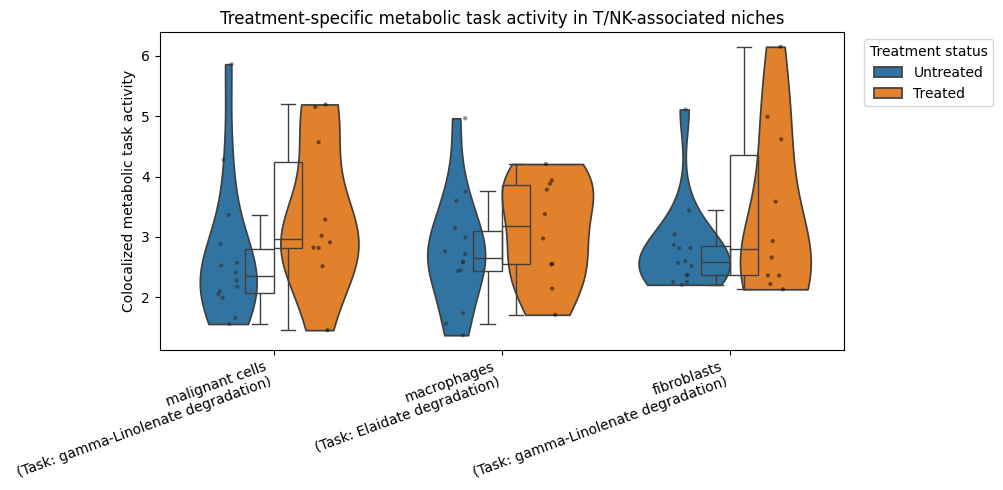

In [28]:
plt.figure(figsize=(10,5)) 

sns.violinplot(
    data=plot_df,
    x="Label",
    y="Metabolic task activity",
    hue="Treatment_Status",
    cut=0,
    inner=None,
    dodge=True
)

sns.boxplot(
    data=plot_df,
    x="Label",
    y="Metabolic task activity",
    hue="Treatment_Status",
    width=0.25,
    showcaps=True,
    boxprops={'facecolor': 'none'},
    showfliers=False,
    dodge=True
)

sns.stripplot(
    data=plot_df,
    x="Label",
    y="Metabolic task activity",
    hue="Treatment_Status",
    dodge=True,
    color="black",
    size=3,
    alpha=0.5
)

plt.ylabel("Colocalized metabolic task activity")
plt.xlabel("")
plt.title("Treatment-specific metabolic task activity in T/NK-associated niches")

plt.xticks(rotation=20, ha="right")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[:2],
    labels[:2],
    title="Treatment status",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


### T/NK infilitrating Significant count based Co-Localization Analysis

In [29]:
def count_cells_colocalized_with_TNK(
    adata,
    infiltration_thr=0.0
):

    labels = adata.obs["Lineage_level3"].copy()

    conn = adata.obsp["spatial_connectivities"].tocsr()

    is_tnk = (labels == "T_NK").values
    is_infil = (adata.obs["TNK_MalignantScore"] > infiltration_thr).values

    tnk_infil_idx = np.where(is_tnk & is_infil)[0]

    if len(tnk_infil_idx) == 0:
        return None

    masks = {
        "Malignant": (labels == "Malignant").values,
        "Macrophage": labels.str.startswith("Macrophage").values,
        "Fibroblast": labels.str.startswith("Fibroblast").values,
    }

    results = {}

    for ct, mask in masks.items():

        total_cells = np.sum(mask)

        if total_cells == 0:
            results[f"{ct}_n_total"] = 0
            results[f"{ct}_n_coloc"] = 0
            results[f"{ct}_pct_coloc"] = np.nan
            continue

        coloc_cells = set()

        for i in tnk_infil_idx:

            neigh = conn.indices[conn.indptr[i]:conn.indptr[i+1]]

            if len(neigh) == 0:
                continue

            ct_neigh = neigh[mask[neigh]]

            coloc_cells.update(ct_neigh.tolist())

        n_coloc = len(coloc_cells)

        results[f"{ct}_n_total"] = int(total_cells)
        results[f"{ct}_n_coloc"] = int(n_coloc)
        results[f"{ct}_pct_coloc"] = n_coloc / total_cells

    return results

In [30]:
input_root = base_dir / "metabolic_tasks_and_reaction_with_TNKscore"

all_rows = []

for pid in os.listdir(input_root):
    adata_path = os.path.join(
        input_root, pid, f"{pid}_with_TNKscore.h5ad"
    )
    if not os.path.exists(adata_path):
        continue

    adata = sc.read_h5ad(adata_path)

    if "Treatment_Status" not in adata.obs.columns:
        continue

    for treatment_status in adata.obs["Treatment_Status"].unique():

        adata_sub = adata[adata.obs["Treatment_Status"] == treatment_status].copy()

        res = count_cells_colocalized_with_TNK(
            adata_sub,
            infiltration_thr = THRESHOLD
        )

        if res is None:
            continue

        res["patient_id"] = pid
        res["Treatment_Status"] = treatment_status

        all_rows.append(res)

df_counts = pd.DataFrame(all_rows)
df_counts

,Malignant_n_total,Malignant_n_coloc,Malignant_pct_coloc,Macrophage_n_total,Macrophage_n_coloc,Macrophage_pct_coloc,Fibroblast_n_total,Fibroblast_n_coloc,Fibroblast_pct_coloc,patient_id,Treatment_Status
0,31596,1710,0.054121,8861,290,0.032728,14332,348,0.024281,1182412B,Untreated
1,49410,1768,0.035782,1579,69,0.043699,9514,196,0.020601,118223A,Untreated
2,86664,7471,0.086206,11518,1332,0.115645,9535,1168,0.122496,468115,Treated
3,10326,1176,0.113887,985,71,0.072081,7170,274,0.038215,1258057B,Untreated
4,36789,560,0.015222,6146,105,0.017084,20256,168,0.008294,120139,Treated
5,2951,182,0.061674,853,23,0.026964,893,19,0.021277,114262,Treated
6,71956,5640,0.078381,7691,870,0.113119,15058,1247,0.082813,1182623B,Untreated
7,5818,93,0.015985,1388,8,0.005764,2286,14,0.006124,1228762B,Untreated
8,9146,87,0.009512,7255,16,0.002205,33885,36,0.001062,1204245B,Untreated
9,47733,10004,0.209582,17010,1158,0.068078,46865,1175,0.025072,120153,Treated


In [31]:
# df_counts.to_csv('colocalization_with_TNK_Cells.csv', index=False)

In [32]:
plot_df = df_counts.melt(
    id_vars=["patient_id", "Treatment_Status"],
    value_vars=[
        "Malignant_pct_coloc",
        "Macrophage_pct_coloc",
        "Fibroblast_pct_coloc"
    ],
    var_name="Cell type",
    value_name="Proportion colocalized"
)

plot_df["Cell type"] = plot_df["Cell type"].str.replace("_pct_coloc", "")

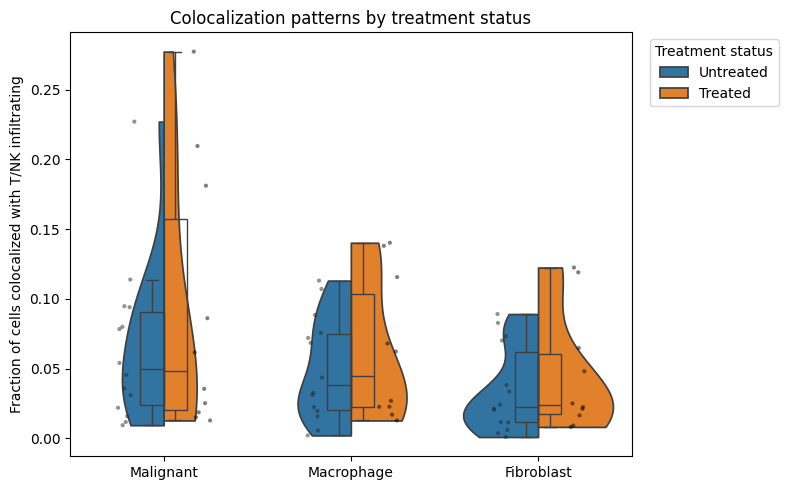

In [33]:
plt.figure(figsize=(8,5))

sns.violinplot(
    data=plot_df,
    x="Cell type",
    y="Proportion colocalized",
    hue="Treatment_Status",
    split=True,
    inner=None,
    cut=0
)

sns.boxplot(
    data=plot_df,
    x="Cell type",
    y="Proportion colocalized",
    hue="Treatment_Status",
    width=0.25,
    showcaps=True,
    boxprops={'facecolor': 'none'},
    showfliers=False,
    dodge=True
)

sns.stripplot(
    data=plot_df,
    x="Cell type",
    y="Proportion colocalized",
    hue="Treatment_Status",
    dodge=True,
    color="black",
    size=3,
    alpha=0.5
)

plt.ylabel("Fraction of cells colocalized with T/NK infiltrating")
plt.xlabel("")
plt.title("Colocalization patterns by treatment status")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Treatment status", bbox_to_anchor=(1.02,1), loc="upper left")

plt.tight_layout()
plt.show()


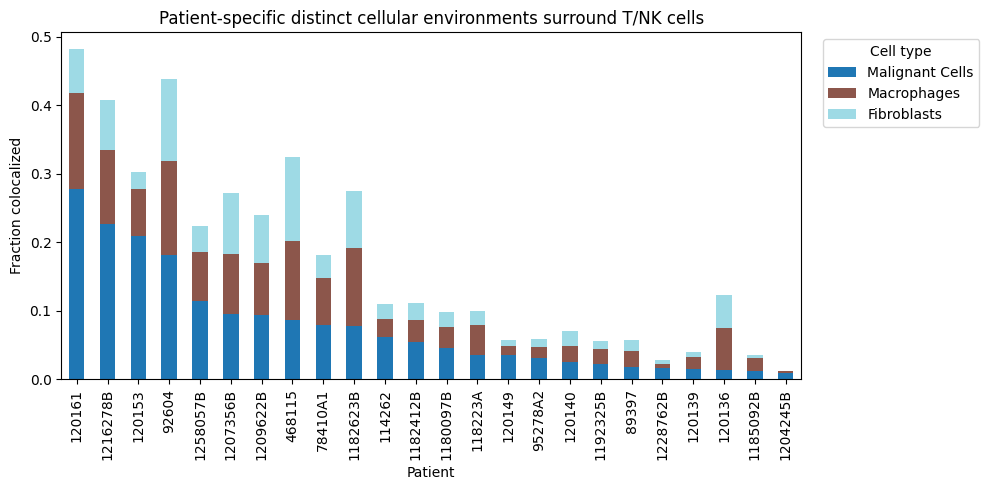

In [34]:
stack_df = df_counts.set_index("patient_id")[[
    "Malignant_pct_coloc",
    "Macrophage_pct_coloc",
    "Fibroblast_pct_coloc"
]]

stack_df = stack_df.sort_values("Malignant_pct_coloc", ascending=False)

stack_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10,5),
    colormap="tab20"
)

plt.ylabel("Fraction colocalized")
plt.xlabel("Patient")
plt.title("Patient-specific distinct cellular environments surround T/NK cells")
plt.legend(
    title="Cell type",
    labels=["Malignant Cells","Macrophages","Fibroblasts"],
    bbox_to_anchor=(1.02,1),
    loc="upper left"
)
plt.tight_layout()
plt.show()


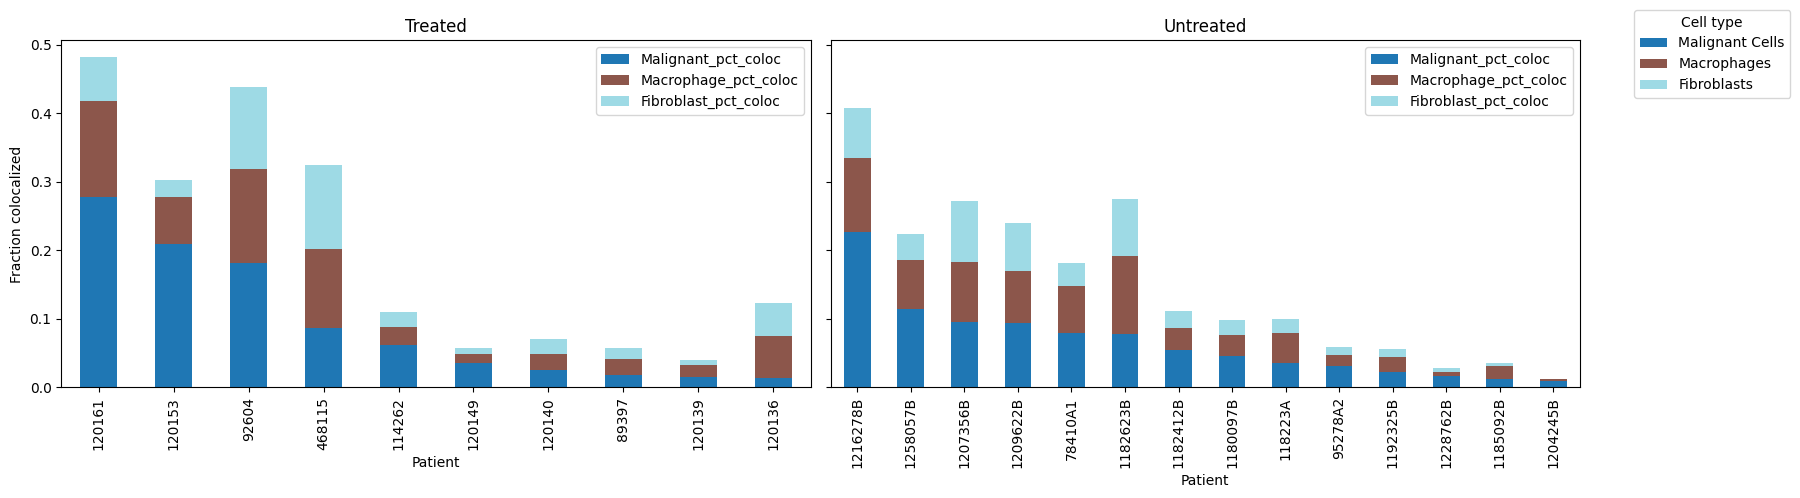

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16,5), sharey=True)

for ax, status in zip(axes, ["Treated", "Untreated"]):
    
    df_group = df_counts[df_counts["Treatment_Status"] == status]
    
    stack_df = df_group.set_index("patient_id")[[
        "Malignant_pct_coloc",
        "Macrophage_pct_coloc",
        "Fibroblast_pct_coloc"
    ]]
    
    stack_df = stack_df.sort_values("Malignant_pct_coloc", ascending=False)

    stack_df.plot(
        kind="bar",
        stacked=True,
        colormap="tab20",
        ax=ax
    )
    
    ax.set_title(f"{status}")
    ax.set_xlabel("Patient")
    ax.set_ylabel("Fraction colocalized")

# Single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    ["Malignant Cells","Macrophages","Fibroblasts"],
    title="Cell type",
    bbox_to_anchor=(1.02,1),
    loc="upper left"
)

plt.tight_layout()
plt.show()

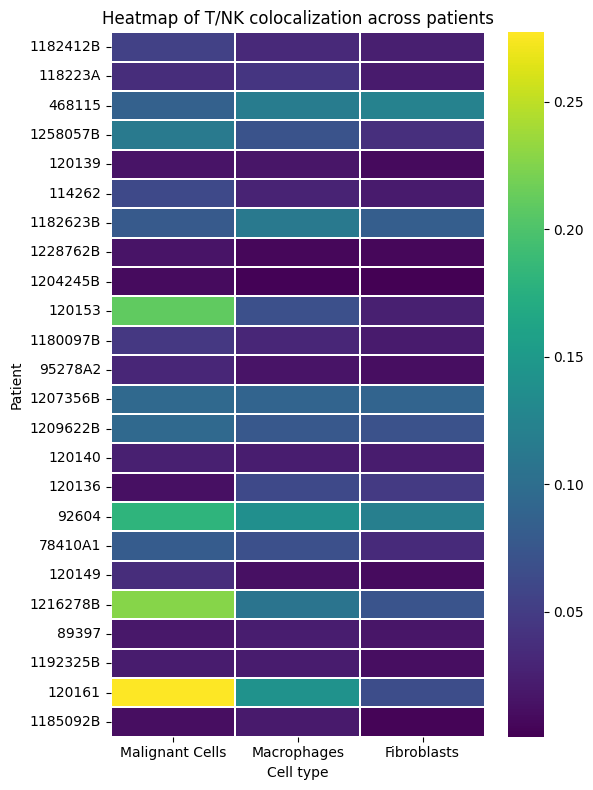

In [36]:
heat_df = df_counts.set_index("patient_id")[[
    "Malignant_pct_coloc",
    "Macrophage_pct_coloc",
    "Fibroblast_pct_coloc"
]]

plt.figure(figsize=(6,8))
ax = sns.heatmap(
    heat_df,
    cmap="viridis",
    linewidths=0.3
)

ax.set_xticklabels(
    ["Malignant Cells", "Macrophages", "Fibroblasts"],
    rotation=0
)

plt.title("Heatmap of T/NK colocalization across patients")
plt.ylabel("Patient")
plt.xlabel("Cell type")
plt.tight_layout()
plt.show()


## Run a t-test (across task) between macr/fibr/mal close with T/NK cells and far away

In [37]:
def ttest_close_vs_far(
    adata,
    infiltration_thr=0.0
):

    conn = adata.obsp["spatial_connectivities"].tocsr()
    labels = adata.obs["Lineage_level3"]
    task_mat = adata.obsm["met_tasks"]
    task_names = list(adata.uns["met_task_names"])

    is_tnk = (labels == "T_NK").values
    is_infil = (adata.obs["TNK_MalignantScore"] > infiltration_thr).values

    tnk_infil_idx = np.where(is_tnk & is_infil)[0]

    if len(tnk_infil_idx) == 0:
        return None

    close_cells = set()

    for i in tnk_infil_idx:
        neigh = conn.indices[conn.indptr[i]:conn.indptr[i+1]]
        close_cells.update(neigh.tolist())

    close_cells = np.array(list(close_cells))
    all_idx = np.arange(adata.n_obs)
    far_cells = np.setdiff1d(all_idx, close_cells)

    celltype_masks = {
        "Macrophage": labels.str.startswith("Macrophage").values,
        "Fibroblast": labels.str.startswith("Fibroblast").values,
        "Malignant": (labels == "Malignant").values
    }

    results = []

    for ct, mask in celltype_masks.items():

        ct_close = close_cells[mask[close_cells]]
        ct_far = far_cells[mask[far_cells]]

        if len(ct_close) < 3 or len(ct_far) < 3:
            continue

        for tidx, task in enumerate(task_names):

            vals_close = task_mat[ct_close, tidx]
            vals_far = task_mat[ct_far, tidx]

            stat, pval = ttest_ind(
                vals_close,
                vals_far,
                equal_var=False
            )

            results.append({
                "CellType": ct,
                "Task": task,
                "mean_close": np.mean(vals_close),
                "mean_far": np.mean(vals_far),
                "t_stat": stat,
                "p_value": pval,
                "n_close": len(vals_close),
                "n_far": len(vals_far)
            })

    return pd.DataFrame(results)

In [38]:
def run_ttest_all_patients(
    input_root,
    infiltration_thr=0.0
):

    patients = [
        p for p in input_root.iterdir()
        if p.is_dir()
    ]

    results = []

    for p in tqdm(patients):

        pid = p.name
        adata_path = p / f"{pid}_with_TNKscore.h5ad"

        if not adata_path.exists():
            print(f"Skipping {pid} (no TNKscore file)")
            continue

        try:
            adata = sc.read_h5ad(adata_path)

            treatment_status = adata.obs["Treatment_Status"].iloc[0]

            df = ttest_close_vs_far(
                adata,
                infiltration_thr=infiltration_thr
            )

            if df is None or len(df) == 0:
                continue

            df["patient_id"] = pid
            df["treatment_status"] = treatment_status
            results.append(df)

        except Exception as e:
            print(f"FAILED on {pid}: {e}")

    if len(results) == 0:
        return None

    df_all = pd.concat(results, ignore_index=True)

    # Global FDR correction
    df_all["p_adj_global"] = multipletests(
        df_all["p_value"],
        method="fdr_bh"
    )[1]

    return df_all

In [39]:
df_ttest_tnk = run_ttest_all_patients(input_root = output_root, 
                                      infiltration_thr = THRESHOLD)
df_ttest_tnk

100%|██████████| 24/24 [00:22<00:00,  1.05it/s]


,CellType,Task,mean_close,mean_far,t_stat,p_value,n_close,n_far,patient_id,treatment_status,p_adj_global
0,Macrophage,(R)-3-Hydroxybutanoate synthesis,3.121351,3.272011,-0.601827,0.547728,290,8571,1182412B,Untreated,0.731252
1,Macrophage,ATP generation from glucose (hypoxic condition...,3.121351,3.272011,-0.601827,0.547728,290,8571,1182412B,Untreated,0.731252
2,Macrophage,ATP regeneration from glucose (normoxic condit...,1.287187,1.361470,-1.006610,0.314899,290,8571,1182412B,Untreated,0.544364
3,Macrophage,Acetoacetate synthesis,3.121351,3.272011,-0.601827,0.547728,290,8571,1182412B,Untreated,0.731252
4,Macrophage,Alanine degradation,3.120318,3.047996,0.681338,0.496166,290,8571,1182412B,Untreated,0.696047
...,...,...,...,...,...,...,...,...,...,...,...
7195,Malignant,beta-Alanine degradation,2.837756,3.047615,-1.786764,0.075395,210,17576,1185092B,Untreated,0.213887
7196,Malignant,beta-Alanine synthesis,4.997920,5.537108,-1.427144,0.154999,210,17576,1185092B,Untreated,0.346367
7197,Malignant,cis-vaccenic acid degradation,6.076208,6.351323,-1.395724,0.164254,210,17576,1185092B,Untreated,0.360158
7198,Malignant,cis-vaccenic acid synthesis,1.388862,1.580917,-3.108302,0.002138,210,17576,1185092B,Untreated,0.010689


In [40]:
alpha = 0.05
df_sig = df_ttest_tnk[df_ttest_tnk["p_adj_global"] < alpha].copy()
df_sig = df_sig.sort_values("p_adj_global")
df_sig

,CellType,Task,mean_close,mean_far,t_stat,p_value,n_close,n_far,patient_id,treatment_status,p_adj_global
5967,Malignant,Synthesis of L-kynurenine from tryptophan,1.418833,0.843940,24.693496,9.256345e-133,15642,53259,1216278B,Untreated,2.221523e-129
5970,Malignant,Synthesis of anthranilate from tryptophan,1.418833,0.843940,24.693496,9.256345e-133,15642,53259,1216278B,Untreated,2.221523e-129
5976,Malignant,Synthesis of kynate from tryptophan,1.418833,0.843940,24.693496,9.256345e-133,15642,53259,1216278B,Untreated,2.221523e-129
5979,Malignant,Synthesis of quinolinate from tryptophan,0.774167,0.482269,24.513524,6.738833e-131,15642,53259,1216278B,Untreated,9.703920e-128
5968,Malignant,Synthesis of N-formylanthranilate from tryptophan,0.774167,0.482269,24.513524,6.738833e-131,15642,53259,1216278B,Untreated,9.703920e-128
...,...,...,...,...,...,...,...,...,...,...,...
6286,Malignant,Trafficking to endosomes (Clathrin Vesicles),1.163392,1.242950,-2.516170,1.208217e-02,694,36339,89397,Treated,4.843630e-02
6573,Malignant,Synthesis of galactosyl glucosyl ceramide (lin...,0.623461,0.671060,-2.513671,1.211136e-02,933,41466,1192325B,Untreated,4.849935e-02
6587,Malignant,Triacylglycerol synthesis,0.623461,0.671060,-2.513671,1.211136e-02,933,41466,1192325B,Untreated,4.849935e-02
1971,Fibroblast,Synthesis of estradiol-17beta (E2) from andros...,0.417233,0.458581,-2.507369,1.226490e-02,1247,13811,1182623B,Untreated,4.908688e-02


In [46]:
df_sig.to_csv('ttest_results_close_vs_far_TNK_infiltrating_cells_sig_tasks.csv', index=False)

In [42]:
sig_counts = (
    df_sig
    .groupby(["CellType"])["Task"]
    .nunique()
    .reset_index(name="n_significant_tasks")
)

sig_counts

,CellType,n_significant_tasks
0,Fibroblast,91
1,Macrophage,100
2,Malignant,100


In [43]:
sig_per_patient = (
    df_sig
    .groupby(["patient_id", "CellType"])["Task"]
    .nunique()
    .reset_index(name="n_significant_tasks")
)
sig_per_patient

,patient_id,CellType,n_significant_tasks
0,114262,Macrophage,19
1,114262,Malignant,1
2,1180097B,Fibroblast,2
3,1180097B,Macrophage,21
4,1180097B,Malignant,37
...,...,...,...
57,92604,Macrophage,67
58,92604,Malignant,9
59,95278A2,Fibroblast,5
60,95278A2,Macrophage,31


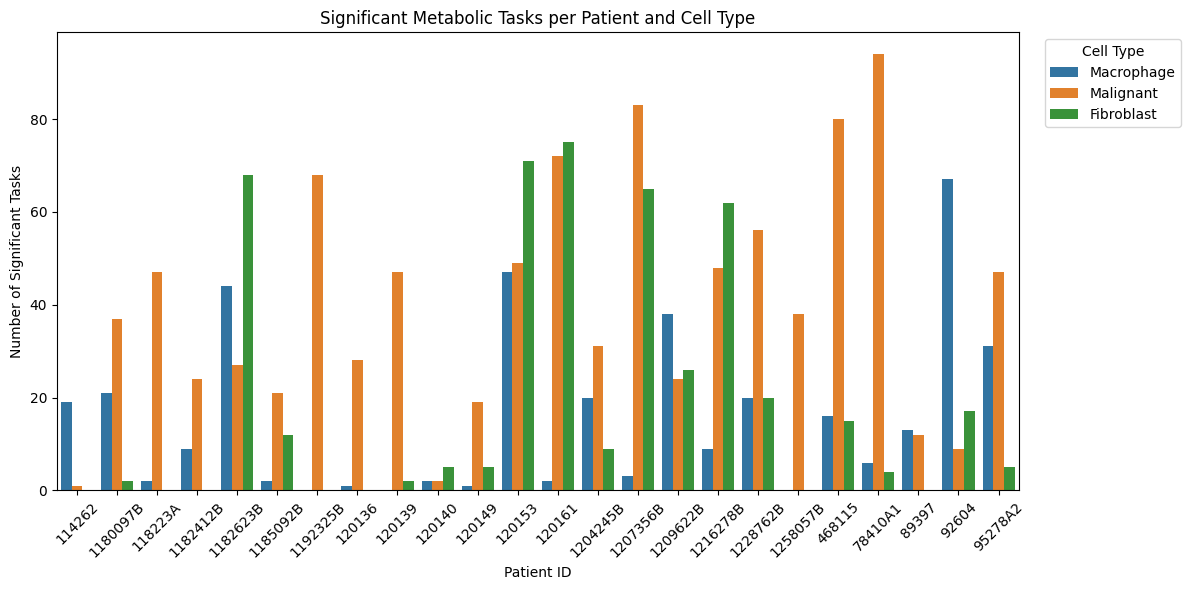

In [44]:
plt.figure(figsize=(12,6))

sns.barplot(
    data=sig_per_patient,
    x="patient_id",
    y="n_significant_tasks",
    hue="CellType"
)

plt.xticks(rotation=45)
plt.xlabel("Patient ID")
plt.ylabel("Number of Significant Tasks")
plt.title("Significant Metabolic Tasks per Patient and Cell Type")
plt.legend(title="Cell Type", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [45]:
sig_per_treatment_status = (
    df_sig
    .groupby(["treatment_status", "CellType"])["Task"]
    .nunique()
    .reset_index(name="n_significant_tasks")
)
sig_per_treatment_status

,treatment_status,CellType,n_significant_tasks
0,Treated,Fibroblast,88
1,Treated,Macrophage,90
2,Treated,Malignant,91
3,Untreated,Fibroblast,91
4,Untreated,Macrophage,91
5,Untreated,Malignant,100
